### Evaluate Topic Model in Python: Latent Dirichlet Allocation (LDA)

In the previous article, I introduced the concept of topic modeling and walked through the code for developing your first topic model using Latent Dirichlet Allocation (LDA) method in the python using gensim implementation.

Pursuing on that understanding, in this article, I'll go a few steps deeper by outlining the framework to quantitatively evaluate topic models through the measure of topic coherence and share the code template in python using Gensim implementation to allow for end-to-end model development.

### Why evaluate topic models?

![img](https://tinyurl.com/y3xznjwq)

We know probabilistic topic models, such as LDA, are popular tools for analysis of the text, providing both a predictive and latent topic representation of the corpus. There is a longstanding assumption that the latent space discovered by these models is meaningful and useful, and evaluating such assumptions is challenging due to its unsupervised training process. There is a no-gold standard list of topics to compare against every corpus.

However, it is equally important to identify if a trained model is objectively good or bad, as well have an ability to compare different models/methods and to do so, we require an objective measure for the quality. Traditionally, and still for many practical applications, to evaluate if "the correct thing" has been learned about the corpus, we use implicit knowledge and "eyeballing" approaches. Ideally, we'd like to capture this information in a single metric that can be maximized, and compared. Let's take a look at roughly what approaches are commonly used for the evaluation:

**Eye Balling Models**
- Top N words
- Topics / Documents

**Intrinsic Evaluation Metrics**
- Capturing model semantics
- Topics interpretability

**Human Judgements**
- What is a topic

**Extrinsic Evaluation Metrics/Evaluation at task**
- Is model good at performing predefined tasks, such as classification

Natural language is messy, ambiguous and full of subjective interpretation, and sometimes trying to cleanse ambiguity reduces the language to an unnatural form. Nevertheless, in this article, we'll explore more about topic coherence, and how we can use it to quantitatively justify the model selection.

### What is Topic Coherence?

Perplexity is often used as an example of an intrinsic evaluation measure. It comes from the language modeling community and aims to capture how surprised a model is of new data it has not seen before. It is measured as the normalized log-likelihood of a held-out test set.

Focussing on the log-likelihood part, you can think of the perplexity metric as measuring how probable some new unseen data is given the model that was learned earlier. That is to say, how well does the model represent or reproduce the statistics of the held-out data.

However, past research has shown that predictive likelihood (or equivalently, perplexity) and human judgment are often not correlated, and even sometimes slightly anti-correlated. And that served as a motivation for more work trying to model the human judgment, and thus `Topic Coherence`.

The topic coherence concept combines a number of papers into one framework that allows evaluating the coherence of topics inferred by a topic model. But,

#### What is topic coherence?
Topic Coherence measures score a single topic by measuring the degree of semantic similarity between high scoring words in the topic. These measurements help distinguish between topics that are semantically interpretable topics and topics that are artifacts of statistical inference. But,

#### What is coherence?
A set of statements or facts is said to be coherent, if they support each other. Thus, a coherent fact set can be interpreted in a context that covers all or most of the facts. An example of a coherent fact set is "the game is a team sport", "the game is played with a ball", "the game demands great physical efforts"

### Coherence Measures

1. `C_v` measure is based on a sliding window, one-set segmentation of the top words and an indirect confirmation measure that uses normalized pointwise mutual information (NPMI) and the cosine similarity
2. `C_p` is based on a sliding window, one-preceding segmentation of the top words and the confirmation measure of Fitelson's coherence
3. `C_uci` measure is based on a sliding window and the pointwise mutual information (PMI) of all word pairs of the given top words
4. `C_umass` is based on document cooccurrence counts, a one-preceding segmentation and a logarithmic conditional probability as confirmation measure
5. `C_npmi` is an enhanced version of the C_uci coherence using the normalized pointwise mutual information (NPMI)
6. `C_a` is baseed on a context window, a pairwise comparison of the top words and an indirect confirmation measure that uses normalized pointwise mutual information (NPMI) and the cosine similarity

### Model Implementation
1. Loading Data
2. Data Cleaning
3. Phrase Modeling: Bi-grams and Tri-grams
4. Data Transformation: Corpus and Dictionary
5. Base Model
6. Hyper-parameter Tuning
7. Final model
8. Visualize Results

** **

For this tutorial, we’ll use the dataset of papers published in NeurIPS (NIPS) conference which is one of the most prestigious yearly events in the machine learning community. The CSV data file contains information on the different NeurIPS papers that were published from 1987 until 2016 (29 years!). These papers discuss a wide variety of topics in machine learning, from neural networks to optimization methods, and many more.

<img src="https://s3.amazonaws.com/assets.datacamp.com/production/project_158/img/nips_logo.png" alt="The logo of NIPS (Neural Information Processing Systems)">

Let’s start by looking at the content of the file

** **
#### Step 1: Loading Data
** **

In [1]:
# Importing modules
import pandas as pd
import os
import warnings
warnings.filterwarnings('ignore')

# Read data into papers
df = pd.read_excel('Job_data.xlsx')

** **
#### Step 2: Data Cleaning
** **

Since the goal of this analysis is to perform topic modeling, we will solely focus on the text data from each paper, and drop other metadata columns

In [2]:
df = df.drop(columns=['Unnamed: 0', 'location_and_id', 'posting_date', 'country_name',
                      'alpha_2', 'alpha_3', 'un_code', 'link', 'city', 'job_id'])
df = df[df.company=='Facebook']

In [3]:
df = df.drop_duplicates(subset='qualifications', keep="last")
df = df.reset_index(drop=True)

In [4]:
df["information"] = df["description"] + df["qualifications"]
df["paper_text"] = df["description"] + df["qualifications"]

In [5]:
papers = df[["paper_text"]]

In [6]:
# # Remove the columns
# papers = papers.drop(columns=['id', 'title', 'abstract', 
#                               'event_type', 'pdf_name', 'year'], axis=1)

# # sample only 100 papers
# papers = papers.sample(100)

# # Print out the first rows of papers
# papers.head()

##### Remove punctuation/lower casing

Next, let’s perform a simple preprocessing on the content of paper_text column to make them more amenable for analysis, and reliable results. To do that, we’ll use a regular expression to remove any punctuation, and then lowercase the text

In [7]:
# Load the regular expression library
import re

# Remove punctuation
papers['paper_text_processed'] = papers['paper_text'].map(lambda x: re.sub('[,\.!?]', '', x))

# Convert the titles to lowercase
papers['paper_text_processed'] = papers['paper_text_processed'].map(lambda x: x.lower())

# Print out the first rows of papers
papers['paper_text_processed'].head()

0    lead the ideation technical development and la...
1    lead the ideation technical development and la...
2    display strong leadership organizational and e...
3    lead a team through the ideation technical dev...
4    lead a team through the ideation technical dev...
Name: paper_text_processed, dtype: object

##### Tokenize words and further clean-up text

Let’s tokenize each sentence into a list of words, removing punctuations and unnecessary characters altogether.

In [8]:
import gensim
from gensim.utils import simple_preprocess

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data = papers.paper_text_processed.values.tolist()
data_words = list(sent_to_words(data))

print(data_words[:1][0][:30])

['lead', 'the', 'ideation', 'technical', 'development', 'and', 'launch', 'of', 'innovative', 'products', 'establish', 'shared', 'vision', 'across', 'the', 'company', 'by', 'building', 'consensus', 'on', 'priorities', 'leading', 'to', 'product', 'execution', 'drive', 'product', 'development', 'with', 'team']


** **
#### Step 3: Phrase Modeling: Bigram and Trigram Models
** **

Bigrams are two words frequently occurring together in the document. Trigrams are 3 words frequently occurring. Some examples in our example are: 'back_bumper', 'oil_leakage', 'maryland_college_park' etc.

Gensim's Phrases model can build and implement the bigrams, trigrams, quadgrams and more. The two important arguments to Phrases are min_count and threshold.

In [9]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

#### Remove Stopwords, Make Bigrams and Lemmatize

The phrase models are ready. Let’s define the functions to remove the stopwords, make trigrams and lemmatization and call them sequentially.

In [10]:
new_stopwords = ['age', 'sexual', 'gender', 'disability', 'race', 'religion', 'belief', 'opportunity', 'employer',
                 'discrimate', 'opportunity', 'equal', 'national', 'origin', 'national', 'veteran', 'orientation',
                 'legally', 'problems', 'solutions', 'processing', 'state', 'peer', 'environment', 'proven',
                 'visit', 'https', 'status', 'jobs', 'amazon', 'diverse', 'individual', 'protected', 'discriminate',
                 'disabilities', 'individuals', 'workplace', 'inclusive', 'please', 'us', 'en', 'new', 'committed',
                 'demonstrated', 'minimum', 'current', 'system', 'pattern', 'fundamental',
                 'strong', 'degree', 'year', 'one', 'least', 'identity', 'accommodation', 'years', 'e g', 'ability',
                 'request', 'basis', 'g', 's', 'record', 'experience', 'working', 'etc', 'e', 'knowledge', 'using', 'team',
                 'design', 'bachelor', 'solution', 'field', 'related', 'work', 'hands', 'building', 'relevant',
                 'industry', 'equivalent', 'business', 'problem', 'skill', 'skills', 'application', 'track', 'similar', 'plus',
                 'including', 'professional', 'c c', 'reliability', 'role', 'etl', 'fluid', 'messenger', 'whatsapp',
                'experiecne', 'team', 'datum', 'year', 'work']

In [11]:
# NLTK Stop words
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
stop_words.extend(new_stopwords)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Sandi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

Let's call the functions in order.

In [13]:
# !python -m spacy download en_core_web_sm

In [14]:
import spacy

# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1][0][:30])

['lead', 'ideation', 'technical', 'development', 'launch', 'innovative', 'product', 'establish_share', 'vision', 'company', 'consensus', 'priority', 'lead', 'product', 'execution', 'drive', 'product', 'development', 'world_class', 'engineer', 'designer', 'integrate_usability', 'study', 'research', 'market', 'analysis', 'product', 'requirement', 'enhance', 'user_satisfaction']


** **
#### Step 4: Data transformation: Corpus and Dictionary
** **

The two main inputs to the LDA topic model are the dictionary(id2word) and the corpus. Let’s create them.

In [15]:
import gensim.corpora as corpora

# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 2), (10, 1), (11, 2), (12, 2), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 2), (28, 1), (29, 1)]


** **
#### Step 5: Base Model 
** **

We have everything required to train the base LDA model. In addition to the corpus and dictionary, you need to provide the number of topics as well. Apart from that, alpha and eta are hyperparameters that affect sparsity of the topics. According to the Gensim docs, both defaults to 1.0/num_topics prior (we'll use default for the base model).

chunksize controls how many documents are processed at a time in the training algorithm. Increasing chunksize will speed up training, at least as long as the chunk of documents easily fit into memory.

passes controls how often we train the model on the entire corpus (set to 10). Another word for passes might be "epochs". iterations is somewhat technical, but essentially it controls how often we repeat a particular loop over each document. It is important to set the number of "passes" and "iterations" high enough.

In [16]:
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=10, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)

** **
The above LDA model is built with 10 different topics where each topic is a combination of keywords and each keyword contributes a certain weightage to the topic.

You can see the keywords for each topic and the weightage(importance) of each keyword using `lda_model.print_topics()`

In [17]:
from pprint import pprint

# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.015*"team" + 0.015*"partner" + 0.014*"manage" + 0.013*"strategy" + '
  '0.012*"drive" + 0.012*"recruit" + 0.012*"management" + 0.011*"datum" + '
  '0.011*"lead" + 0.011*"research"'),
 (1,
  '0.039*"product" + 0.024*"datum" + 0.023*"research" + 0.018*"analysis" + '
  '0.013*"marketing" + 0.013*"quantitative" + 0.012*"team" + 0.011*"strategy" '
  '+ 0.010*"partner" + 0.010*"science"'),
 (2,
  '0.028*"datum" + 0.014*"process" + 0.012*"manage" + 0.011*"stakeholder" + '
  '0.011*"partner" + 0.011*"immigration" + 0.011*"need" + 0.010*"internal" + '
  '0.010*"report" + 0.008*"project"'),
 (3,
  '0.014*"audio" + 0.013*"project" + 0.012*"manage" + 0.012*"product" + '
  '0.011*"change" + 0.011*"team" + 0.010*"management" + 0.009*"functional" + '
  '0.009*"drive" + 0.009*"datum"'),
 (4,
  '0.027*"software" + 0.016*"network" + 0.012*"system" + 0.012*"ar_vr" + '
  '0.012*"real_time" + 0.011*"develop" + 0.010*"engineering" + '
  '0.010*"computer" + 0.010*"debug" + 0.009*"development"'),
 (

#### Compute Model Perplexity and Coherence Score

Let's calculate the baseline coherence score

In [18]:
from gensim.models import CoherenceModel

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Coherence Score:  0.39389188474921344


** **
#### Step 6: Hyperparameter tuning
** **
First, let's differentiate between model hyperparameters and model parameters :

- `Model hyperparameters` can be thought of as settings for a machine learning algorithm that are tuned by the data scientist before training. Examples would be the number of trees in the random forest, or in our case, number of topics K

- `Model parameters` can be thought of as what the model learns during training, such as the weights for each word in a given topic.

Now that we have the baseline coherence score for the default LDA model, let's perform a series of sensitivity tests to help determine the following model hyperparameters: 
- Number of Topics (K)
- Dirichlet hyperparameter alpha: Document-Topic Density
- Dirichlet hyperparameter beta: Word-Topic Density

We'll perform these tests in sequence, one parameter at a time by keeping others constant and run them over the two difference validation corpus sets. We'll use `C_v` as our choice of metric for performance comparison 

In [19]:
# supporting function
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

Let's call the function, and iterate it over the range of topics, alpha, and beta parameter values

In [20]:
import numpy as np
import tqdm

grid = {}
grid['Validation_Set'] = {}

# Topics range
min_topics = 2
max_topics = 11
step_size = 1
topics_range = range(min_topics, max_topics, step_size)

# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')

# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')

# Validation sets
num_of_docs = len(corpus)
corpus_sets = [gensim.utils.ClippedCorpus(corpus, int(num_of_docs*0.75)), 
               corpus]

corpus_title = ['75% Corpus', '100% Corpus']

model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }

# Can take a long time to run
if 1 == 1:
    pbar = tqdm.tqdm(total=(len(beta)*len(alpha)*len(topics_range)*len(corpus_title)))
    
    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
#     i = 1
        # iterate through number of topics
        for k in topics_range:
            # iterate through alpha values
            for a in alpha:
                # iterare through beta values
                for b in beta:
                    # get the coherence score for the given parameters
                    cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=id2word, 
                                                  k=k, a=a, b=b)
                    # Save the model results
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(cv)

                    pbar.update(1)
        pd.DataFrame(model_results).to_csv('./results/lda_tuning_results_top_skills.csv', index=False)
    pbar.close()

100%|██████████| 540/540 [2:30:01<00:00, 16.67s/it]  


In [30]:
result_hy_opt = pd.read_csv('./results/lda_tuning_results_top_skills.csv')
result_hy_opt.head()

,Validation_Set,Topics,Alpha,Beta,Coherence
0,75% Corpus,2,0.01,0.01,0.327254
1,75% Corpus,2,0.01,0.31,0.327254
2,75% Corpus,2,0.01,0.61,0.327254
3,75% Corpus,2,0.01,0.9099999999999999,0.327254
4,75% Corpus,2,0.01,symmetric,0.327254


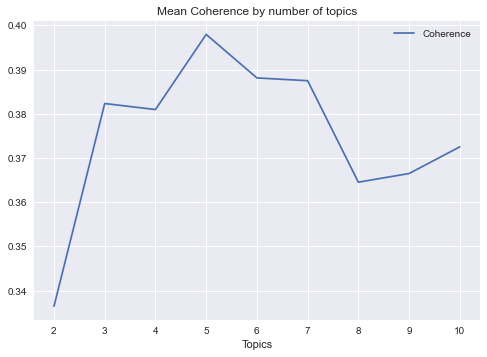

In [39]:
import matplotlib.pyplot as plt
plt.style.use('seaborn')
result_hy_opt.groupby(by=['Topics']).mean().plot()
plt.title('Mean Coherence by number of topics')
plt.show()

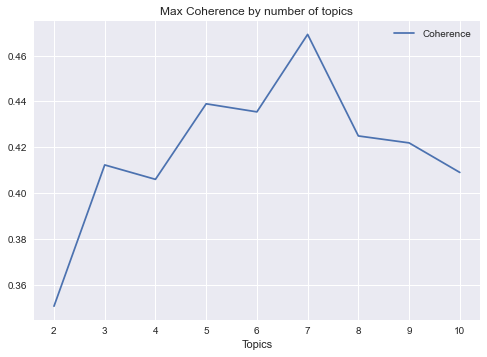

In [40]:
import matplotlib.pyplot as plt
plt.style.use('seaborn')
result_hy_opt.groupby(by=['Topics']).max().plot()
plt.title('Max Coherence by number of topics')
plt.show()

In [95]:
result_hy_opt.groupby(by=['Alpha']).mean()

,Topics,Coherence
Alpha,,
0.01,6.0,0.374598
0.31,6.0,0.376009
0.61,6.0,0.373987
0.9099999999999999,6.0,0.371469
asymmetric,6.0,0.379601
symmetric,6.0,0.375557


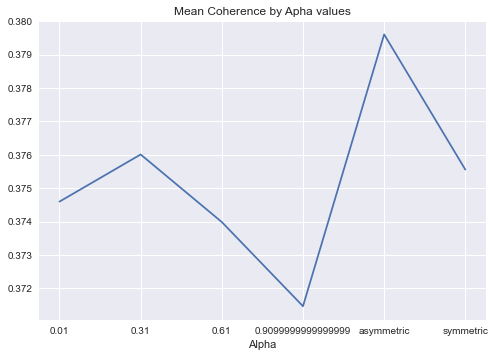

In [99]:
import matplotlib.pyplot as plt
plt.style.use('seaborn')
result_hy_opt.groupby(by=['Alpha']).mean()['Coherence'].plot()
plt.title('Mean Coherence by Apha values')
plt.show()

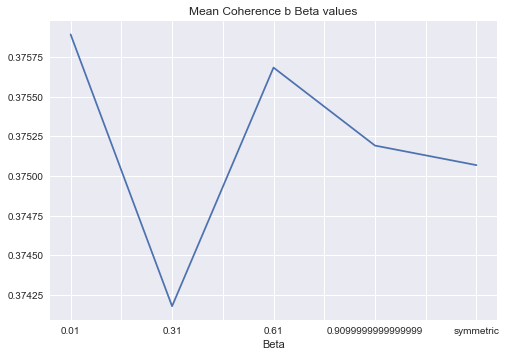

In [98]:
import matplotlib.pyplot as plt
plt.style.use('seaborn')
result_hy_opt.groupby(by=['Beta']).mean()['Coherence'].plot()
plt.title('Mean Coherence b Beta values')
plt.show()

In [42]:
result_hy_opt.sort_values(by='Coherence', ascending=False)

,Validation_Set,Topics,Alpha,Beta,Coherence
173,75% Corpus,7,symmetric,0.9099999999999999,0.469246
158,75% Corpus,7,0.31,0.9099999999999999,0.466774
153,75% Corpus,7,0.01,0.9099999999999999,0.464637
177,75% Corpus,7,asymmetric,0.61,0.443427
92,75% Corpus,5,0.01,0.61,0.438970
...,...,...,...,...,...
472,100% Corpus,8,symmetric,0.61,0.319129
458,100% Corpus,8,0.31,0.9099999999999999,0.318572
473,100% Corpus,8,symmetric,0.9099999999999999,0.315634
453,100% Corpus,8,0.01,0.9099999999999999,0.312288


** **
#### Step 7: Final Model
** **

Based on external evaluation (Code to be added from Excel based analysis), let's train the final model with parameters yielding highest coherence score

In [43]:
num_topics = 7

lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=0.31,
                                           eta=0.91)

In [44]:
from pprint import pprint

# Print the Keyword in the 10 topics
print(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0, '0.013*"team" + 0.012*"manage" + 0.012*"partner" + 0.011*"drive" + 0.011*"management" + 0.011*"strategy" + 0.010*"product" + 0.009*"program" + 0.009*"datum" + 0.009*"cross"'), (1, '0.032*"product" + 0.031*"datum" + 0.016*"research" + 0.014*"analysis" + 0.011*"drive" + 0.010*"team" + 0.010*"quantitative" + 0.009*"strategy" + 0.009*"partner" + 0.009*"marketing"'), (2, '0.004*"datum" + 0.003*"product" + 0.002*"cross" + 0.002*"video" + 0.002*"manage" + 0.002*"partner" + 0.002*"functional" + 0.002*"drive" + 0.002*"process" + 0.002*"team"'), (3, '0.040*"product" + 0.009*"datum" + 0.008*"drive" + 0.008*"development" + 0.008*"technical" + 0.007*"lead" + 0.006*"engineer" + 0.006*"platform" + 0.005*"process" + 0.005*"management"'), (4, '0.015*"system" + 0.013*"software" + 0.013*"computer" + 0.011*"research" + 0.011*"engineering" + 0.009*"develop" + 0.007*"hardware" + 0.007*"science" + 0.007*"development" + 0.006*"machine_learne"'), (5, '0.004*"product" + 0.003*"datum" + 0.002*"drive" + 0.00

** **
#### Step 8: Visualize Results
** **

In [69]:
# import pyLDAvis.gensim
import pyLDAvis.gensim_models as gensimvis
import pickle 
import pyLDAvis

num_topics = 7

lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           passes=100,
                                           alpha=0.31,
                                           eta=0.91)

# Visualize the topics
pyLDAvis.enable_notebook()

LDAvis_data_filepath = os.path.join('./results/ldavis_tuned_'+str(num_topics)+'new')

# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)

# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)

pyLDAvis.save_html(LDAvis_prepared, './results/ldavis_tuned_'+ str(num_topics) +'new.html')

LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6      0.155701  0.031494       1        1  41.284695
1      0.140703 -0.045575       2        1  26.869072
4     -0.026611 -0.150344       3        1  16.965597
0      0.067769  0.097106       4        1  10.665359
3     -0.062648  0.002413       5        1   3.685676
2     -0.138055  0.032428       6        1   0.292529
5     -0.136859  0.032477       7        1   0.237071, topic_info=            Term         Freq        Total Category  logprob  loglift
37       product  1782.000000  1782.000000  Default  30.0000  30.0000
98         datum  1432.000000  1432.000000  Default  29.0000  29.0000
85      software   367.000000   367.000000  Default  28.0000  28.0000
164      recruit   179.000000   179.000000  Default  27.0000  27.0000
40      research   765.000000   765.000000  Default  26.0000  26.0000
..           ...          ...          ...      ...      ...      ...
113  opportunity     0.056643   205.221274   Topic7  -8.3005  -2.1505
85      software     0.056643   367.626578   Topic7  -8.3005  -2.7335
298         task     0.056642    56.291661   Topic7  -8.3005  -0.8570
88          team     0.056642   970.896962   Topic7  -8.3005  -3.7047
335      closely     0.056642   166.302152   Topic7  -8.3005  -1.9402

[483 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
1319      1  0.874935      account
1319      2  0.031248      account
1319      3  0.031248      account
1319      4  0.031248      account
2213      1  0.055222     acoustic
...     ...       ...          ...
53        1  0.313166  world_class
53        2  0.173981  world_class
53        3  0.034796  world_class
53        4  0.139185  world_class
53        5  0.313166  world_class

[1681 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 2, 5, 1, 4, 3, 6])

In [70]:
import numpy as np
pred = np.argmax(lda_model.get_topics(), axis=0)

In [72]:
pred.shape

(4038,)

In [76]:
LDAvis_prepared.topic_info

,Term,Freq,Total,Category,logprob,loglift
37,product,1782.000000,1782.000000,Default,30.0000,30.0000
98,datum,1432.000000,1432.000000,Default,29.0000,29.0000
85,software,367.000000,367.000000,Default,28.0000,28.0000
164,recruit,179.000000,179.000000,Default,27.0000,27.0000
40,research,765.000000,765.000000,Default,26.0000,26.0000
...,...,...,...,...,...,...
113,opportunity,0.056643,205.221274,Topic7,-8.3005,-2.1505
85,software,0.056643,367.626578,Topic7,-8.3005,-2.7335
298,task,0.056642,56.291661,Topic7,-8.3005,-0.8570
88,team,0.056642,970.896962,Topic7,-8.3005,-3.7047


In [77]:
LDAvis_prepared.topic_order

[7, 2, 5, 1, 4, 3, 6]

In [78]:
LDAvis_prepared.token_table

,Topic,Freq,Term
term,,,
1319,1,0.874935,account
1319,2,0.031248,account
1319,3,0.031248,account
1319,4,0.031248,account
2213,1,0.055222,acoustic
...,...,...,...
53,1,0.313166,world_class
53,2,0.173981,world_class
53,3,0.034796,world_class


** **
#### Closing Notes

We started with understanding why evaluating the topic model is essential. Next, we reviewed existing methods and scratched the surface of topic coherence, along with the available coherence measures. Then we built a default LDA model using Gensim implementation to establish the baseline coherence score and reviewed practical ways to optimize the LDA hyperparameters.

Hopefully, this article has managed to shed light on the underlying topic evaluation strategies, and intuitions behind it.

** **
#### References:
1. http://qpleple.com/perplexity-to-evaluate-topic-models/
2. https://www.amazon.com/Machine-Learning-Probabilistic-Perspective-Computation/dp/0262018020
3. https://papers.nips.cc/paper/3700-reading-tea-leaves-how-humans-interpret-topic-models.pdf
4. https://github.com/mattilyra/pydataberlin-2017/blob/master/notebook/EvaluatingUnsupervisedModels.ipynb
5. https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/
6. http://svn.aksw.org/papers/2015/WSDM_Topic_Evaluation/public.pdf
7. http://palmetto.aksw.org/palmetto-webapp/